## 1. Set up the experiment

### 1-1. Import modules

In [1]:
import  os, time
from    pathlib             import  Path
from    tqdm.notebook       import  tqdm
import  pickle

import  numpy                       as  np
import  torch
from    torch                       import  nn, optim
from    torch_geometric.data        import  Data
from    torch_geometric.loader      import  DataLoader

import  yaml

from    custom_modules.dtypes               import  MultiLevelGraph
from    custom_modules.utils                import  get_time_str
from    custom_modules.utils                import  GaussianNormalizer, npzReader
from    custom_modules.utils                import  RandomMultiGridGenerator
from    custom_modules.pytorch.neuralop     import  MultipoleGraphNeuralOperator    as  MGNO
from    custom_modules.pytorch.torch_utils  import  count_parameters


time_str = get_time_str()

### 1-2. Load the configurations

In [2]:
with open("config_train.yaml") as f:
    config = yaml.load(f, Loader = yaml.FullLoader)
    _exp   = config['experiment']
    _data  = config['pde_dataset']
    _graph = config['graph']
    _mgno  = config['mgno']

### 1-3. Set the experiment

In [3]:
# NOTE Training and data preprocess


BATCH_SIZE      = _exp['batch_size']
NUM_EPOCHS      = _exp['num_epochs']
LEARNING_RATE   = _exp['learning_rate']
TRAIN_SIZE      = _exp['train_size']
VAL_SIZE        = _exp['val_size']
DEVICE          = torch.device(f"cuda:{_exp['cuda_index']}")


RESOLUTION      = _data['resolution']
TRAIN_PATH      = Path(_data['path'])
__RANDOM_CHOICE = np.random.choice(1024, TRAIN_SIZE + VAL_SIZE, replace = False)
TRAIN_MASK      = __RANDOM_CHOICE[:TRAIN_SIZE]
VAL_MASK        = __RANDOM_CHOICE[-VAL_SIZE:]


DOWNSAMPLE      = _data['downsample']
GRID            = (RESOLUTION - 1) // DOWNSAMPLE + 1
NUM_NODES       = GRID ** 2


RADII_GEOMETRIC = _graph['radii_geometric']
SAMPLE_SIZES    = _graph['sample_sizes']
NUM_SAMPLING    = _graph['num_sampling']
MAX_NEIGHBORS   = _graph['max_neighbors']

## 2. Preprocess data

### 2-1. Instantiate the storages

In [4]:
train_data: dict[str, torch.Tensor]= {
    'coeff':    None,
    'Kcoeff':   None,
    'Kcoeff_x': None,
    'Kcoeff_y': None,
    'sol':      None,
}
val_data: dict[str, torch.Tensor]= {
    'coeff':    None,
    'Kcoeff':   None,
    'Kcoeff_x': None,
    'Kcoeff_y': None,
    'sol':      None,
}


normalizer: dict[str, GaussianNormalizer] = {
    'coeff':    None,
    'Kcoeff':   None,
    'Kcoeff_x': None,
    'Kcoeff_y': None,
    'sol':      None,
}

### 2-2. Load the train data

In [5]:
# Train data
reader = npzReader(TRAIN_PATH)
for cnt, k in tqdm(enumerate(train_data.keys()), desc = "Preprocessing the train data"):
    # Step 1. Load data
    train_data[k] = torch.from_numpy(reader.get_field(k)[TRAIN_MASK, ::DOWNSAMPLE, ::DOWNSAMPLE])
    train_data[k] = train_data[k].flatten(-1)
    train_data[k] = train_data[k].type(torch.float)
    
    # Step 2. Normalize data
    normalizer[k] = GaussianNormalizer(train_data[k])
    train_data[k] = normalizer[k].encode(train_data[k])


# Validation data
for cnt, k in tqdm(enumerate(val_data.keys()), desc = "Preprocessing the validation data"):
    # Step 1. Load data
    val_data[k] = torch.from_numpy(reader.get_field(k)[VAL_MASK, ::DOWNSAMPLE, ::DOWNSAMPLE])
    val_data[k] = val_data[k].flatten(-1)
    val_data[k] = val_data[k].type(torch.float)
    
    # Step 2. Normalize data (NOTE: Uses the normalizers for the train dataset)
    val_data[k] = normalizer[k].encode(val_data[k])

Preprocessing the train data: 0it [00:00, ?it/s]

Preprocessing the validation data: 0it [00:00, ?it/s]

### 2-3. Construct graphs

In [6]:
# NOTE Generate a grid to set the node and edge attributes


grid_generator  = RandomMultiGridGenerator(
                        domain          = [[0., 1.], [0., 1.]],
                        grid_size       = [GRID, GRID],
                        radii_geometric = RADII_GEOMETRIC,
                        sample_sizes    = SAMPLE_SIZES,
                        max_neighbors   = MAX_NEIGHBORS,
                        allow_loop      = False,
                        
                        sampling_mode = "permutation",
                    )

In [7]:
# NOTE Construct graphs


list_train_data, list_test_data = [], []


for idx in tqdm(range(TRAIN_SIZE)):
    for cnt in range(NUM_SAMPLING):
        # Input information
        _coeff      = train_data[ 'coeff'  ][idx].reshape(NUM_NODES, -1)
        _Kcoeff     = train_data['Kcoeff'  ][idx].reshape(NUM_NODES, -1)
        _Kcoeff_x   = train_data['Kcoeff_x'][idx].reshape(NUM_NODES, -1)
        _Kcoeff_y   = train_data['Kcoeff_y'][idx].reshape(NUM_NODES, -1)
        
        # Sampling
        grid_generator.sample()
        merged_grid_index       = grid_generator.merged_grid_index
        merged_graph_coords     = grid_generator.merged_graph_coordinates
        merged_graph_edge_index = grid_generator.merged_graph_edge_index
        
        merged_edge_index_in_grid = merged_grid_index[merged_graph_edge_index]

        # Define the node feature
        _x = torch.hstack(
            [
                merged_graph_coords,
                _coeff[merged_grid_index],
                _Kcoeff[merged_grid_index],
                _Kcoeff_x[merged_grid_index],
                _Kcoeff_y[merged_grid_index],
            ]
        )
        # Define the node target
        _y = train_data['sol'][idx].reshape(NUM_NODES, -1)[merged_grid_index]
        # Define the edge feature
        _edge_attr = torch.hstack(
            [
                merged_graph_coords[merged_graph_edge_index[0]],
                merged_graph_coords[merged_graph_edge_index[1]],
                _coeff[merged_edge_index_in_grid[0]],
                _coeff[merged_edge_index_in_grid[1]],
            ]
        )
        
        _ranges_node = grid_generator.masks_node
        _ranges_edge = grid_generator.masks_edge
        _lvwise_edge_index = grid_generator.levelwise_edge_index
        
        # Append the new graph
        list_train_data.append(
            Data(
                x = _x,
                y = _y,
                edge_index  = grid_generator.merged_graph_edge_index,
                edge_attr   = _edge_attr,
                
                mask_node  = _ranges_node,
                mask_edge  = _ranges_edge,
                levelwise_edge_index = _lvwise_edge_index,
            )
        )

  0%|          | 0/100 [00:00<?, ?it/s]

[]

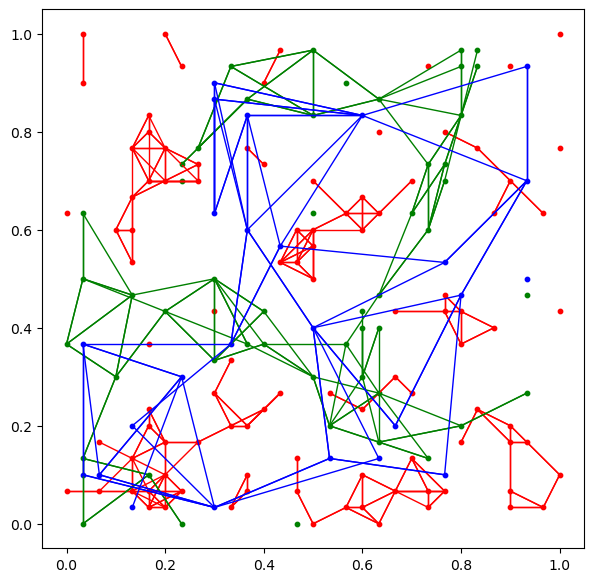

In [8]:
import  matplotlib.pyplot       as      plt
from    custom_modules.plot     import  plot_2d_graph


example = list_train_data[-1]
COLORLIST = ['r', 'g', 'b']


plt.figure(figsize = (7, 7))
for level, color in enumerate(COLORLIST):
    plot_2d_graph(
        example.x[example.mask_node[level], :2],
        example.levelwise_edge_index[level],
        marker_size     = 10,
        marker_color    = color,
        # grid_generator.merged_graph_coordinates[grid_generator.masks_node[level]],
        # grid_generator.levelwise_edge_index[level],
        # marker_size     = 10,
        # marker_color    = color,
    )
plt.plot()

In [9]:
train_loader = DataLoader(list_train_data, batch_size = BATCH_SIZE, shuffle = True)

## 3. Train the model

### 3-1. Initialize the model and instantiate the loss function and the optimizer

In [10]:
mgno = MGNO(**_mgno).to(DEVICE)
print(f"The number of the parameters in the custom GNO\n>>> {count_parameters(mgno)}")
print(mgno)

# for p in mgno.parameters():
#     if p.ndim == 1:
#         nn.init.zeros_(p)
#     else:
#         nn.init.xavier_uniform_(p)

STEP_SIZE = 20
SCHEDULER_GAMMA = 1.0

criterion = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(params = mgno.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP_SIZE, gamma = SCHEDULER_GAMMA)

The number of the parameters in the custom GNO
>>> 701457
MultipoleGraphNeuralOperator(
    lift:       MLP(layer=(6, 16, 32), bias=True, activation=relu)
    hidden:     MultipoleGraphKernelLayer(node_channels=32, edge_channels=6, n_poles=3 (down: 2, iso: 3, up: 2)) x 2 (activation=relu)
    projection: MLP(layer=(32, 16, 1), bias=True, activation=relu)
)


### 3-2. Train the model

In [ ]:
def relative_error(pred: torch.Tensor, target: torch.Tensor) -> float:
    return torch.linalg.norm(pred - target) / (1e-8 + torch.linalg.norm(target)).item()

In [ ]:
train_history = {
    'train_loss':   [],
    'train_error':  [],
    'val_loss':     [],
    'val_error':    [],
    'train_time':   0.0,
}
# normalizer['sol'].to(DEVICE)

elapsed_time = time.time()
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    # NOTE: Train
    if True:
        mgno.train()
        _train_time = time.time()
        train_epoch_loss:  float = 0
        train_epoch_error: float = 0
        
        for batch in train_loader:
            batch: MultiLevelGraph = batch.to(DEVICE)
            train_pred = mgno.forward(batch)
            train_loss = criterion.forward(train_pred, batch.y)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_epoch_loss += train_loss.item() * len(batch)
            train_epoch_error += relative_error(
                normalizer['sol'].decode(train_pred),
                normalizer['sol'].decode(batch.y)
                # train_pred, batch.y
            ) * len(batch)
        
        scheduler.step()
        
        if True:
            _train_time = time.time() - _train_time
            train_history['train_time'] += _train_time
            train_epoch_loss    = train_epoch_loss / TRAIN_SIZE
            train_epoch_error   = train_epoch_error / TRAIN_SIZE
            train_history['train_loss'].append(train_epoch_loss)
            train_history['train_error'].append(train_epoch_error)
    
    
    
    # Report
    if True:
        if epoch % 10 == 0 or epoch == 1:
            print(f"[ Epoch {epoch} / {NUM_EPOCHS} | learning_rate: {optimizer.param_groups[0]['lr']:.3e}]")
            for k in train_history.keys():
                if k == "train_time":
                    continue
                try:
                    print(f"* {k:15s}: {train_history[k][-1]:.4e}")
                except:
                    True
    
elapsed_time = time.time() - elapsed_time
print(f"Elapsed time: {int(elapsed_time)} seconds")

### 3-3. Save the model and the train history

In [ ]:
mgno.cpu()

# Save the model
os.makedirs(time_str, exist_ok = True)
torch.save(mgno.state_dict(), f"{time_str}/gno_darcy{RESOLUTION}_res{GRID}.pth")

# # Save the normalizer, which will also be used in prediction
# normalizer['sol'].cpu()
# torch.save(normalizer, f"{time_str}/gno_darcy{RESOLUTION}_res{GRID}_normalizer.pth")

# Save the history
with open(f"{time_str}/gno_darcy{RESOLUTION}_res{GRID}.pickle", "wb") as f:
    pickle.dump(train_history, f)

## End of file